# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.init as I
import torchsummary as summary

In [2]:
! git clone https://github.com/udacity/P1_Facial_Keypoints.git

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6049 (delta 3), reused 7 (delta 2), pack-reused 6038 (from 1)
Receiving objects: 100% (6049/6049), 329.53 MiB | 29.80 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (5805/5805), done.


In [3]:
!ls
!pwd

P1_Facial_Keypoints  sample_data
/content


In [4]:
key_pts_frame = pd.read_csv("./P1_Facial_Keypoints/data/training_frames_keypoints.csv")
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n,1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)
print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

print('Image Name',   image_name)
print('Landmarks shape:',key_pts.shape[0])
print("first 4 key: {}".format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]
Image Name Luis_Fonsi_21.jpg
Landmarks shape: 68
first 4 key: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [5]:
# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


# Show some images

In [6]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:,0],key_pts[:,1], s=20, marker=".", c="m")

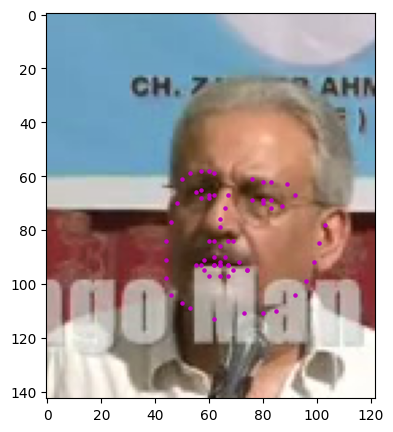

(143, 122, 4)


In [7]:
n = 222
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n,1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)
plt.figure(figsize=(5,5))
img = mpimg.imread(os.path.join("./P1_Facial_Keypoints/data/training/", image_name))
show_keypoints(img, key_pts)
plt.show()
print(img.shape)


## dataset loader and transformation

In [8]:
class FacialKeypointsDataset(Dataset):
    """Face Keypoints Dataset."""

    def __init__(self, csv_file, root_dir, transformation = None, train = True):
      """
      Args:
      csv_file (string): path to csv file with annotations
      root_dir (string): directory with all images
      transformation (callable, optional):  Optional transform to be applied
                                            on a sample.
      """
      self.key_pts_frame = pd.read_csv(csv_file)
      if train == True:
        self.root_dir = os.path.join(root_dir,"training/")
      else:
        self.root_dir = os.path.join(root_dir,"test/")
      self.transformation = transformation

    def __len__(self):
      return len(self.key_pts_frame)

    def __getitem__(self, idx):
      image_path = os.path.join(self.root_dir, self.key_pts_frame.iloc[idx, 0])
      image = mpimg.imread(image_path)

      # if image has an alpha color channel, delete it
      if(image.shape[2] == 4):
            image = image[:,:,0:3]
      key_pts = self.key_pts_frame.iloc[idx, 1:].values
      key_pts = key_pts.astype('float').reshape(-1, 2)
      sample = {'image': image, 'keypoints': key_pts}
      if self.transformation:
            sample = self.transformation(sample)
      return sample



In [9]:
face_dataset = FacialKeypointsDataset(csv_file='./P1_Facial_Keypoints/data/training_frames_keypoints.csv',
                                    root_dir='./P1_Facial_Keypoints/data')
print("length of dataset =", len(face_dataset))

length of dataset = 3462


0 (175, 173, 3) (68, 2)
1 (218, 196, 3) (68, 2)
2 (132, 128, 3) (68, 2)
3 (123, 90, 3) (68, 2)
4 (232, 195, 3) (68, 2)


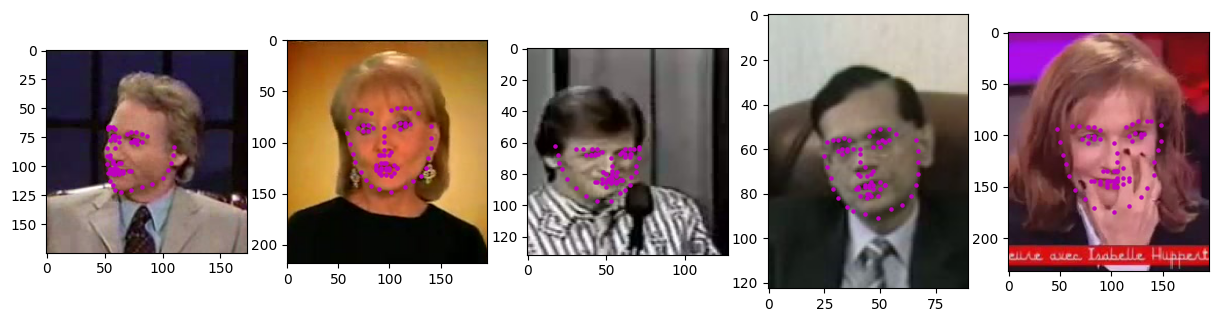

In [34]:
fig = plt.figure(figsize = (15,5))
num_disp = 5
for i in range(num_disp):
  rand_idx = np.random.randint(0,len(face_dataset))
  sample = face_dataset[rand_idx]
  print(i, sample['image'].shape, sample['keypoints'].shape)
  fig.add_subplot(1,num_disp,i+1)
  show_keypoints(sample['image'], sample['keypoints'])

## Transforms
* normalization
* rescale
* random crop
* ToTensor

In [35]:
# normalization
class Normalize(object):
  """Convert a color image to grayscale and normalize the color range to [0,1]."""

  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']
    # scale keypoints to be centered around 0 with a range of [-1, 1]
    # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
    image = np.copy(image)
    key_pts = np.copy(key_pts)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image/255.0
    key_pts = (key_pts - 100)/50.0
    return {'image': image, 'keypoints': key_pts}

# rescale

class Rescale(object):
  """Rescale the image in a sample to a given size.
  Args:
    output_size (tuple or int): Desired output size. If tuple, output is
    matched to output_size. If int, smaller of image edges is matched
    to output_size keeping aspect ratio the same.
  """
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size

  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']
    h, w = image.shape[:2]
    if isinstance(self.output_size, int):
      if h > w:
        new_h, new_w = self.output_size * h / w, self.output_size
      else:
        new_h, new_w = self.output_size , self.output_size * w / h
    else:
      new_h, new_w = self.output_size
    new_h, new_w = int(new_h), int(new_w)
    image = cv2.resize(image , (new_w, new_h))
    key_pts = key_pts * [new_w/w, new_h/h]
    return {'image': image, 'keypoints': key_pts}

class RandomCrop(object):
  """ implement random crop in a sample
  Args:
      output_size (tuple or int): Desired output size. If int, square crop
      is made.
  """
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    if isinstance(output_size, int):
      self.output_size = (output_size, output_size)
    else:
      assert len(output_size) == 2 # check if there are w and h in output_size var
      self.output_size = output_size
  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']
    h, w = image.shape[:2]
    new_h, new_w = self.output_size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    image = image[top:top+new_h, left:left+new_w]
    key_pts = key_pts - [left, top]

    return {'image': image, 'keypoints': key_pts}

class ToTensor(object):
  """Convert ndarrays in sample to Tensors."""
  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']

    # if image has no grayscale color channel, add one
    if(len(image.shape) == 2):
      # add that third color dim
      image = image.reshape(image.shape[0], image.shape[1], 1)

    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    image = image.transpose((2, 0, 1))

    return {'image': torch.from_numpy(image),
            'keypoints': torch.from_numpy(key_pts)}



## test transformation

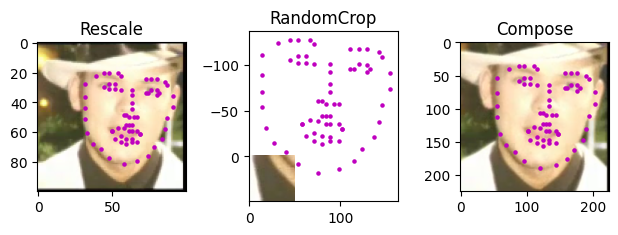

In [37]:
# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 200
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [38]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='./P1_Facial_Keypoints/data/training_frames_keypoints.csv',
                                          root_dir='./P1_Facial_Keypoints/data/',
                                             transformation=data_transform)

# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())



Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


## loading and batching data

In [39]:
train_dataset = FacialKeypointsDataset(csv_file='./P1_Facial_Keypoints/data/training_frames_keypoints.csv',
                                          root_dir='./P1_Facial_Keypoints/data/',
                                             transformation=data_transform)

test_dataset = FacialKeypointsDataset(csv_file='./P1_Facial_Keypoints/data/test_frames_keypoints.csv',
                                          root_dir='./P1_Facial_Keypoints/data/',
                                             train = False,
                                             transformation=data_transform)

batch_size = 24
train_loader = DataLoader(transformed_dataset,batch_size = batch_size, shuffle = True, num_workers= 2)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

# Neural network definition

In [73]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 5)
    # (w-f+2p )/s +1
    # ( 224 -5 + 2 *0 )/1 +1 = 220
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2,2)
    # 110
    self.conv2 = nn.Conv2d(8, 16, 3)
    # ( 110 - 3 + 2 *0 )/1 +1 = 108
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2,2)
    # 54
    self.conv3 = nn.Conv2d(16, 32, 3)
    # 52
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(2,2)
    # 26
    self.fc1 = nn.Linear(32*26*26, 500)
    self.drop_fc1 = nn.Dropout(p=0.4)
    self.fc2 = nn.Linear(500, 136)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.relu3(x)
    x = self.pool3(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.drop_fc1(x)
    x = self.fc2(x)
    return x


In [74]:
model = Net()
summary.summary(model, (1, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 220, 220]             208
              ReLU-2          [-1, 8, 220, 220]               0
         MaxPool2d-3          [-1, 8, 110, 110]               0
            Conv2d-4         [-1, 16, 108, 108]           1,168
              ReLU-5         [-1, 16, 108, 108]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 32, 52, 52]           4,640
              ReLU-8           [-1, 32, 52, 52]               0
         MaxPool2d-9           [-1, 32, 26, 26]               0
           Linear-10                  [-1, 500]      10,816,500
          Dropout-11                  [-1, 500]               0
           Linear-12                  [-1, 136]          68,136
Total params: 10,890,652
Trainable params: 10,890,652
Non-trainable params: 0
-------------------------

In [75]:
batch_size = 24
learning_rate = 0.001
epochs = 5
momentum= 0.9

optimizer = optim.SGD
criterion = nn.MSELoss

# using cross entropy whcih combines softmax and NLL loss
optimizer = optimizer(model.parameters(), lr= learning_rate, momentum= momentum)
# stochastic gradient descent with a small learning rate AND some momentum
criterion = criterion()


In [76]:
def train_net(n_epochs):

    # prepare the net for training
    model.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = model(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % batch_size == batch_size-1:    # print every 24 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [77]:
train_net(2)

Epoch: 1, Batch: 24, Avg. Loss: 0.014001936614513398
Epoch: 1, Batch: 48, Avg. Loss: 0.01371748435497284
Epoch: 1, Batch: 72, Avg. Loss: 0.01334889417886734
Epoch: 1, Batch: 96, Avg. Loss: 0.01028271758556366
Epoch: 1, Batch: 120, Avg. Loss: 0.006998317569494247
Epoch: 1, Batch: 144, Avg. Loss: 0.006101308211684227
Epoch: 2, Batch: 24, Avg. Loss: 0.005300369530916214
Epoch: 2, Batch: 48, Avg. Loss: 0.006071675971150398
Epoch: 2, Batch: 72, Avg. Loss: 0.005074298962950707
Epoch: 2, Batch: 96, Avg. Loss: 0.005470900863409042
Epoch: 2, Batch: 120, Avg. Loss: 0.005072476178407669
Epoch: 2, Batch: 144, Avg. Loss: 0.005508739367127418
Finished Training


## save model

In [81]:
# ! mkdir saved_models
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'
torch.save(model.state_dict(), model_dir+model_name)


## test model

0 (224, 224) (68, 2)
1 (224, 224) (68, 2)
2 (224, 224) (68, 2)
3 (224, 224) (68, 2)
4 (224, 224) (68, 2)


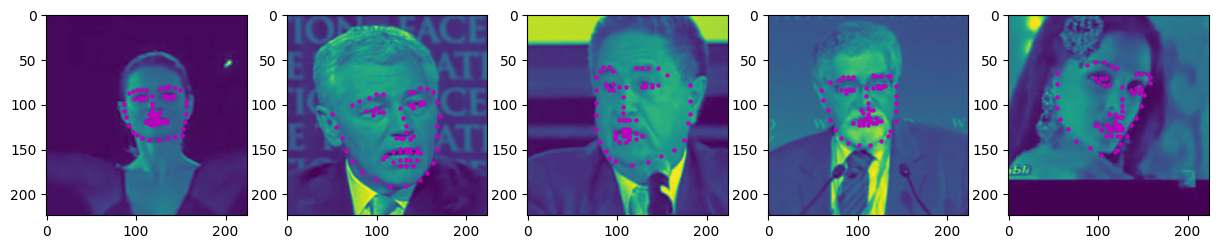

In [82]:
model.eval()

test_iter = test_loader.__iter__()
data = test_iter._next_data()
images = data['image']
np_img = np.squeeze(images.numpy())
key_pts = data['keypoints']

# flatten pts
key_pts = key_pts.view(key_pts.size(0), -1)

# convert variables to floats for regression loss
key_pts = key_pts.type(torch.FloatTensor)
images = images.type(torch.FloatTensor)

# forward pass to get outputs
output_pts = model(images)

pts = (np.squeeze(output_pts.data.numpy()).reshape(batch_size,-1,2) *50.0 ) +100
main_pts = (np.squeeze(key_pts.data.numpy()).reshape(batch_size,-1,2) *50.0 ) +100
fig = plt.figure(figsize = (15,5))
num_disp = 5
for i in range(num_disp):
  sample_img = np_img[i]
  sample_pts = pts[i]
  sample_main_pts = main_pts[i]
  print(i, sample_img.shape, sample_pts.shape)
  fig.add_subplot(1,num_disp,i+1)
  show_keypoints(sample_img, sample_main_pts)


In [83]:
pts.shape

(24, 68, 2)

## feature visualization


[[-0.09201828  0.0340227  -0.00733258  0.1167675   0.18675977]
 [ 0.02832965 -0.13180698 -0.10860549  0.04362414 -0.01774179]
 [ 0.01229164  0.01502814 -0.00639734 -0.14469323  0.03102604]
 [-0.1496863   0.18174413 -0.01769422 -0.01506527  0.05744793]
 [-0.03448218 -0.11977367 -0.1606415   0.02299331 -0.12909618]]
(5, 5)


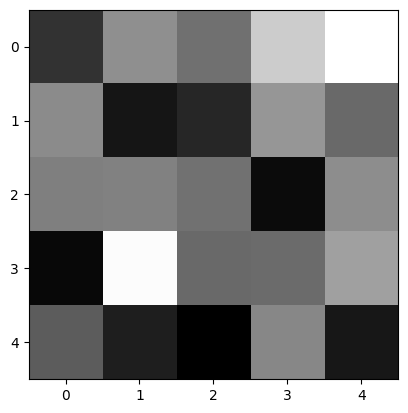

In [84]:
# get the weights of first convolution layer
weights = model.conv1.weight.data
w = weights.numpy()

filter_index = 0
print(w[filter_index][0])
print(w[filter_index][0].shape)

plt.imshow(w[filter_index][0], cmap='gray')


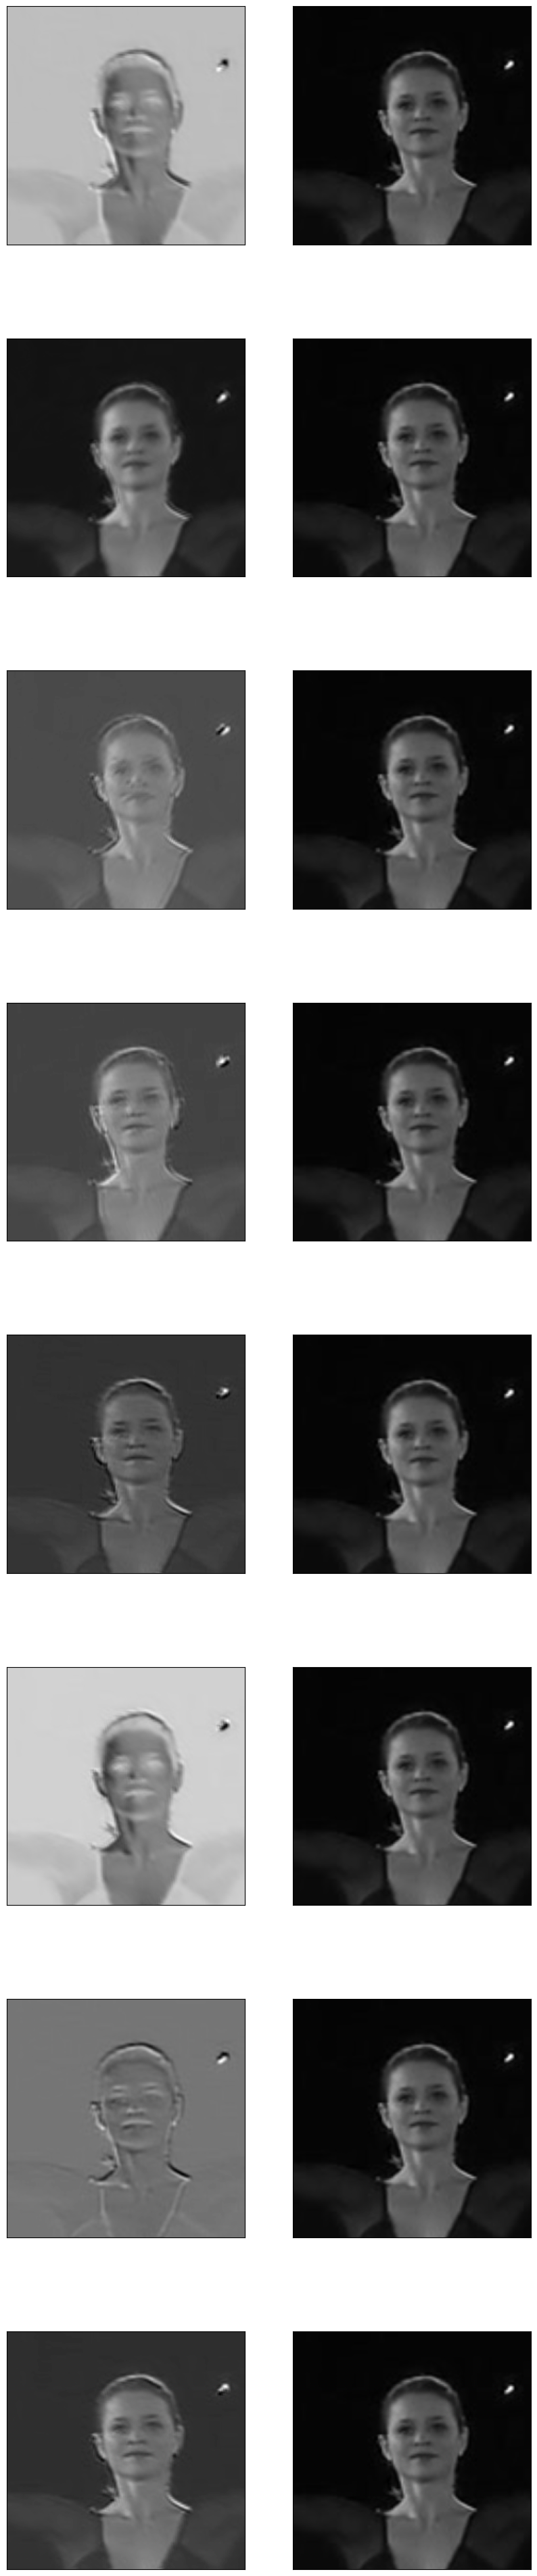

In [85]:
fig = plt.figure(figsize = (10,50))

for i in range(len(w)):
  plt.subplot(len(w),2,i * 2 + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(cv2.filter2D(np_img[0], -1, w[i][0]),cmap="gray")
  plt.subplot(len(w),2, i * 2 + 2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(np_img[0],cmap="gray")

plt.show()


## download files

In [86]:
from google.colab import files
import zipfile

!zip -r saved_models.zip saved_models

files.download('saved_models.zip')

  adding: saved_models/ (stored 0%)
  adding: saved_models/keypoints_model_1.pt (deflated 9%)
  adding: saved_models/.ipynb_checkpoints/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>